In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import factorial
from scipy.optimize import minimize
from scipy.linalg import svd
from scipy.interpolate import interp1d
import scipy.stats
from tqdm import tqdm
import starry
print(starry.__version__)
import earthshine
import tensorflow as tf

1.0.0.dev0


In [4]:
# Load the coastlines
import matplotlib.image as mpimg
coastlines = mpimg.imread("../data/coastlines.png")
csum = np.sum(coastlines, axis=-1)
coastlines[csum < 4] = [0, 0, 0, 1]
coastlines[csum == 4] = [1, 1, 1, 0]

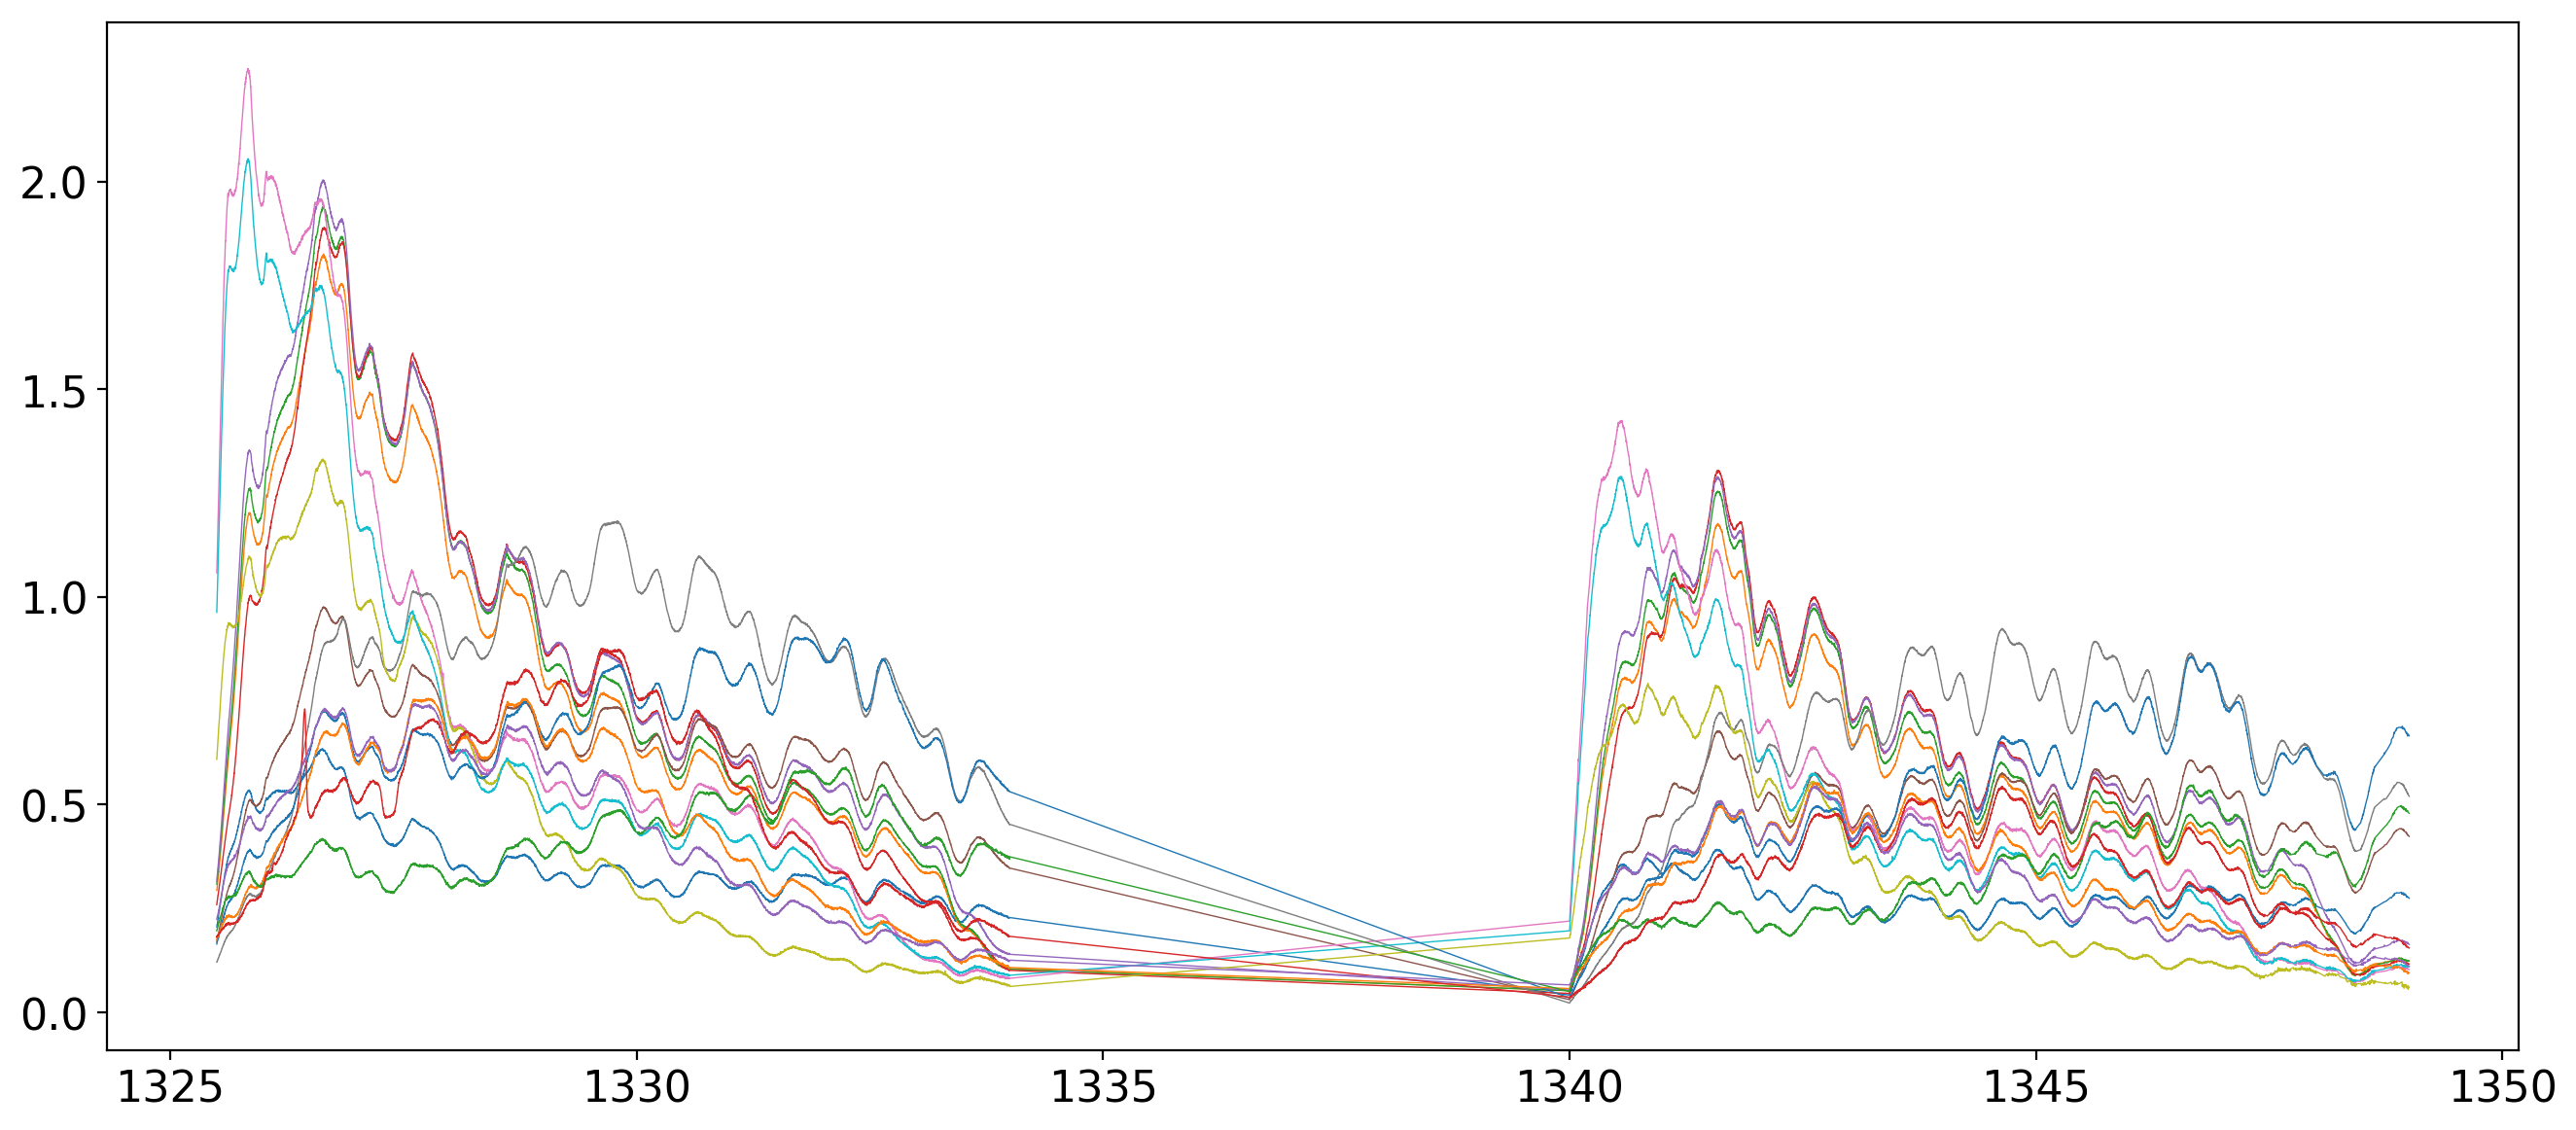

In [5]:
# Load the data for sector 1
data = np.load("../data/sector01-data.npz")
time = data["time"]
flux = data["flux"][:15]
flux_err = data["flux_err"][:15]
bkg = data["bkg"][:15]

# Remove the background so we can do PLD
for i in range(len(flux)):
    flux[i] -= bkg[i]

# Plot it
fig, ax = plt.subplots(1, figsize=(16, 7))
for b, f in zip(bkg, flux):
    line, = ax.plot(time, f, lw=0.5)

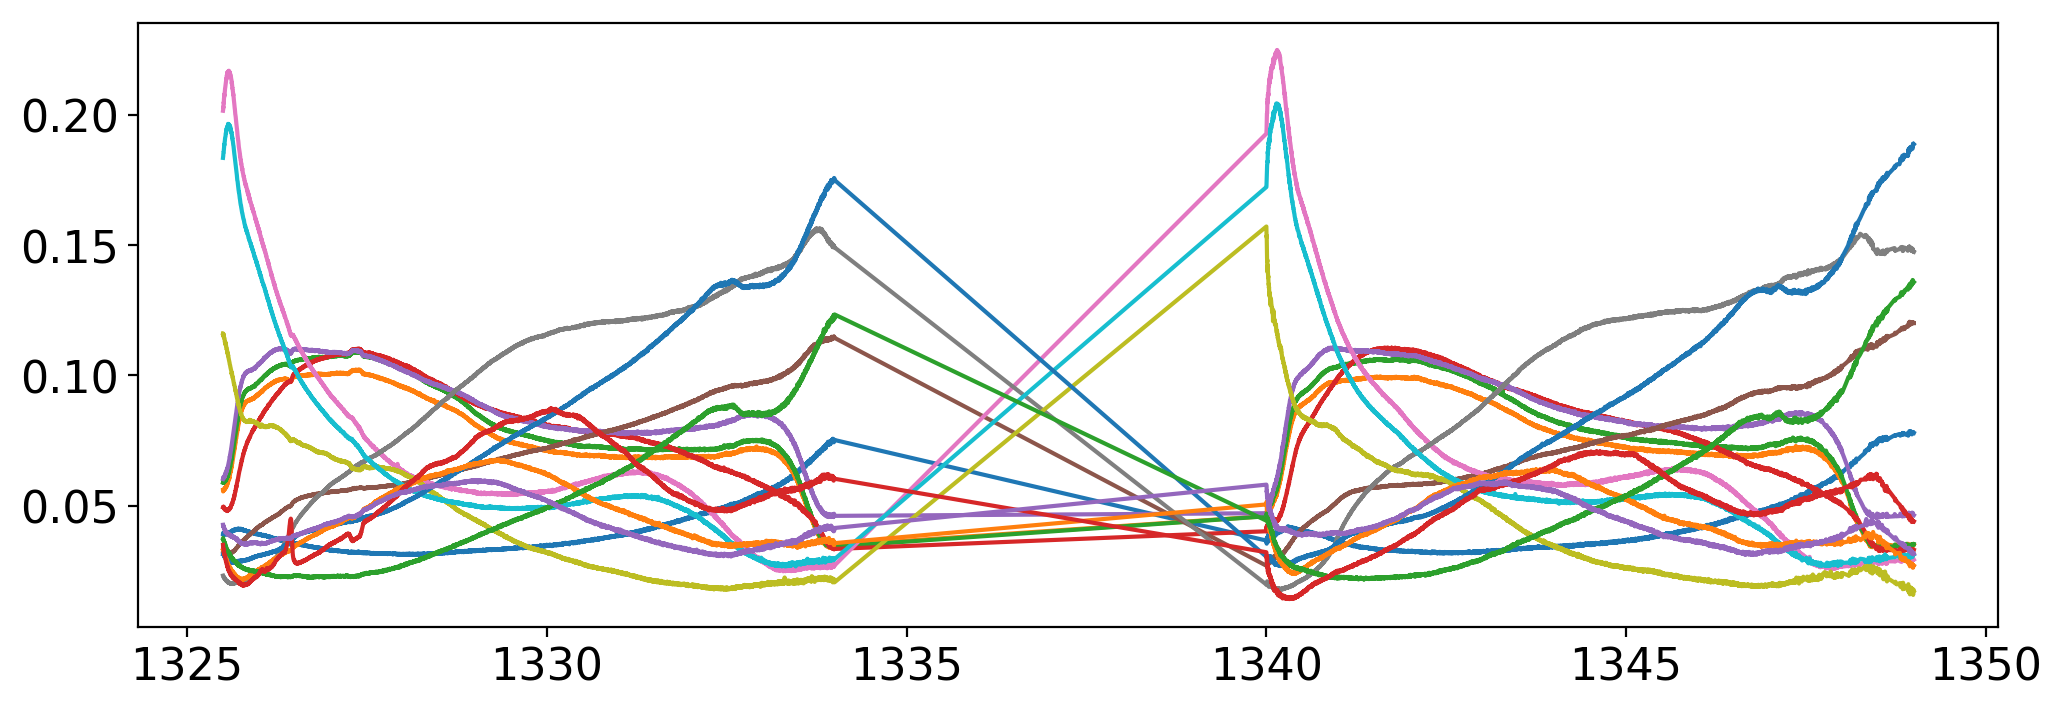

In [6]:
# Compute the PLD basis
flux_sum = np.sum(flux, axis=0)
B = np.hstack([(flux[n] / flux_sum).reshape(-1, 1) for n in range(len(flux))])
B = np.hstack((np.ones((len(time), 1)), B))
for n in range(1, len(flux) + 1):
    plt.plot(time, B[:, n])

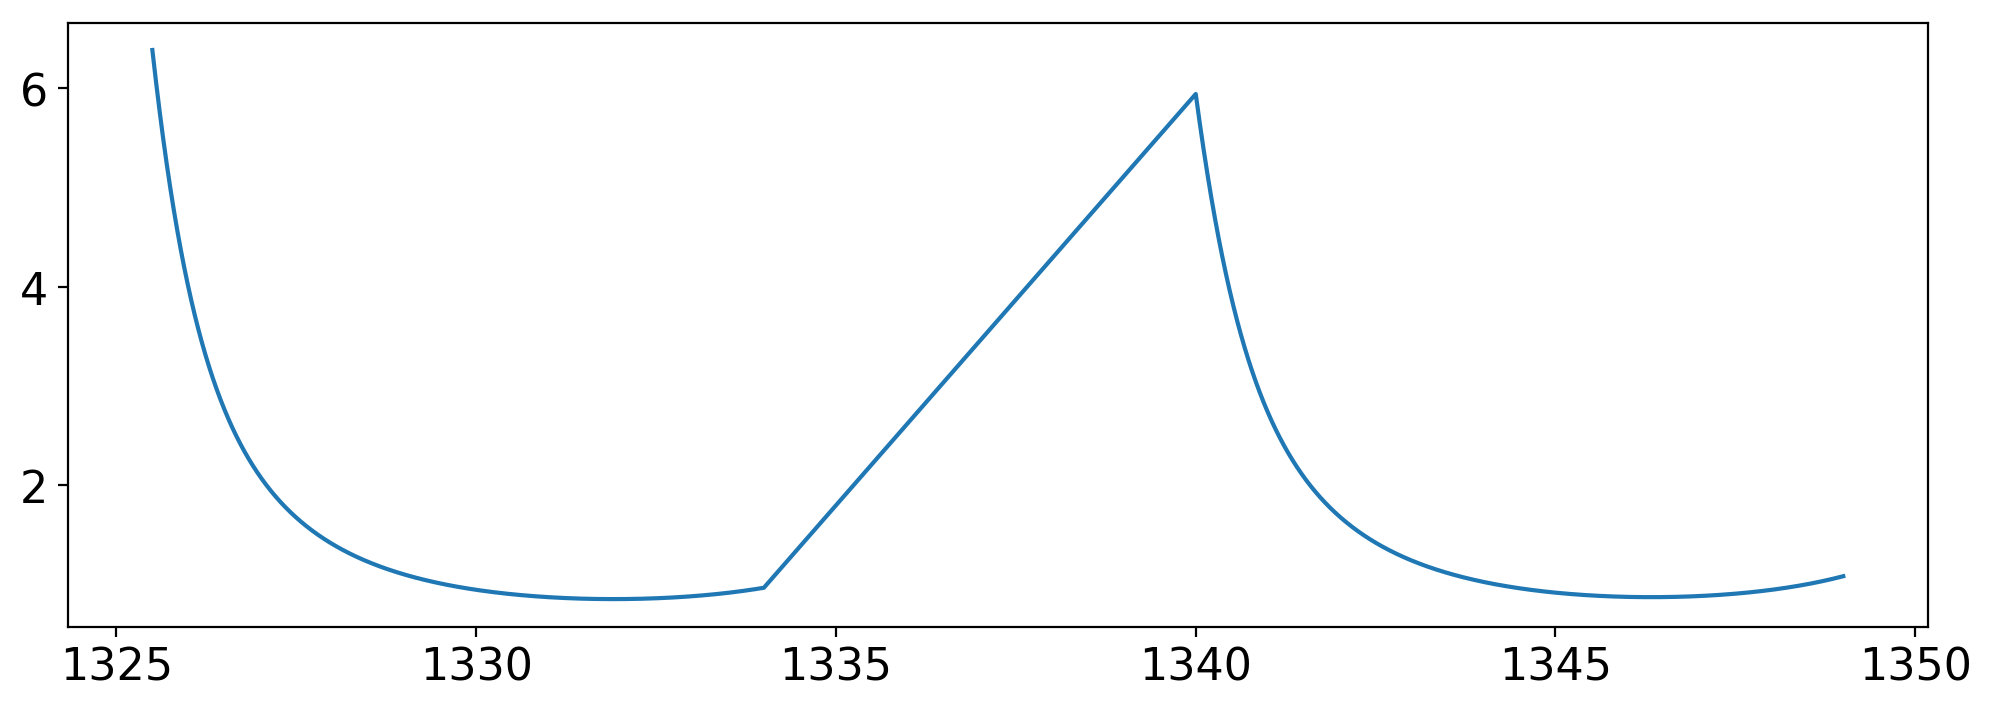

In [7]:
# Compute the TESS-Earth distance as a function of time
tvec = earthshine.tess_earth_vector(time)
tr = np.sqrt(tvec[0] ** 2 + tvec[1] ** 2 + tvec[2] ** 2)

# This is the amplitude of the Earthshine (not a fit parameter)
amp = (1 / tr ** 2).reshape(-1, 1)
amp /= np.nanmedian(amp)
amp = amp.reshape(-1)
plt.plot(time, amp);

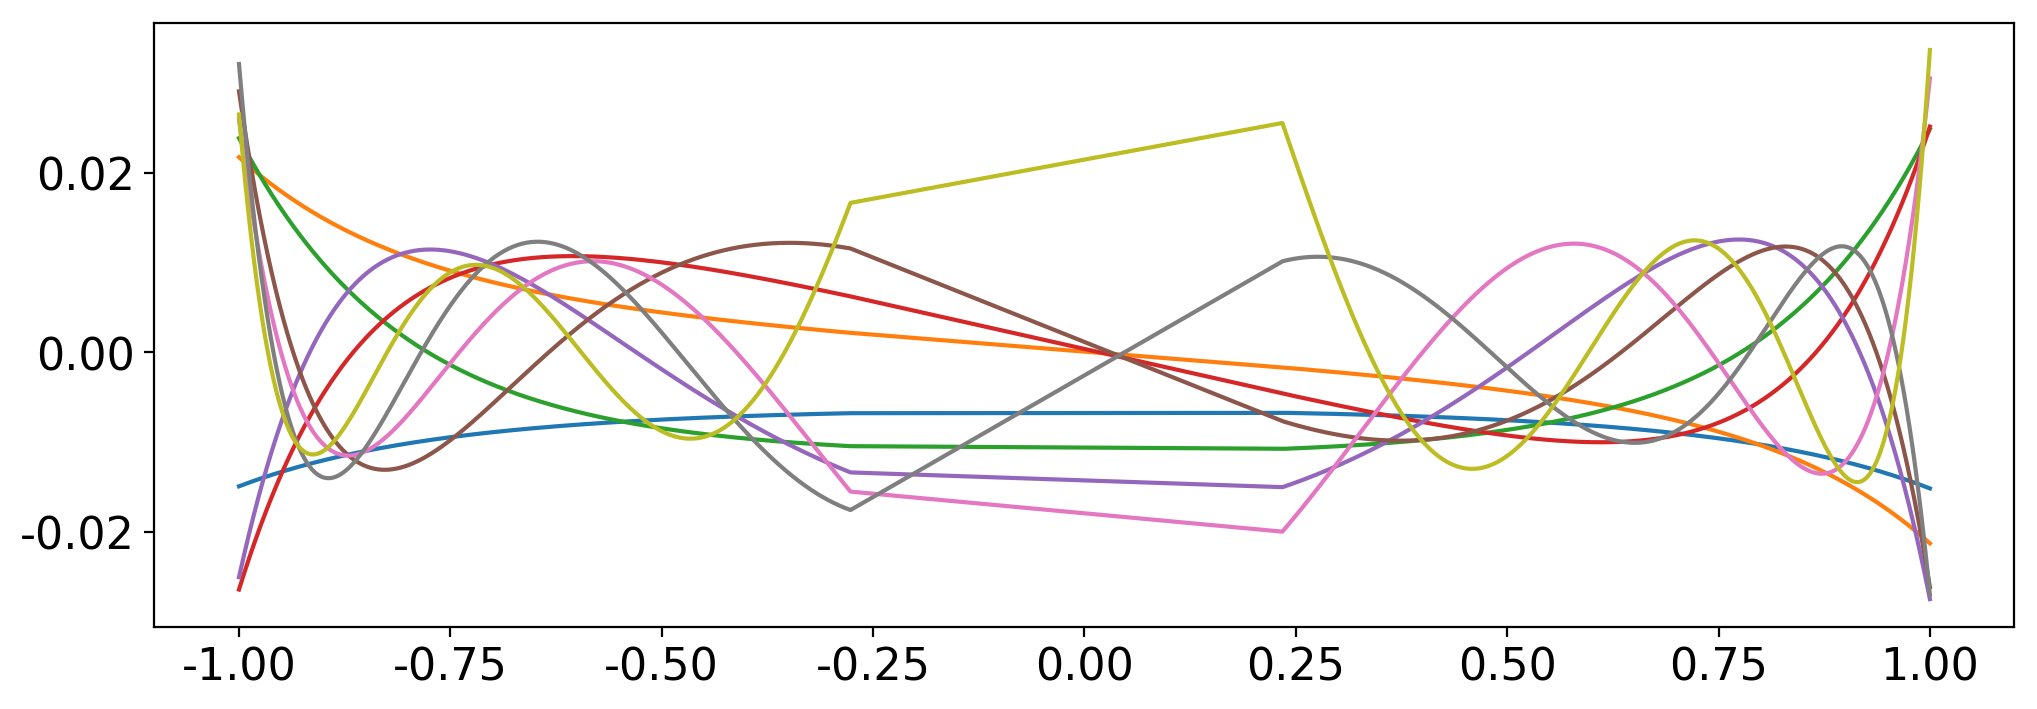

In [8]:
# Construct an orthogonal temporal basis
nt = 10
t = 2 * ((time - time[0]) / (time[-1] - time[0]) - 0.5)
C = np.vander(t, N=nt, increasing=True)
U, _, _ = svd(C)
C = np.hstack((np.ones((len(t), 1)), U[:, :nt - 1]))
plt.plot(t, C[:, 1:]);

100%|██████████| 11363/11363 [00:02<00:00, 4607.00it/s]


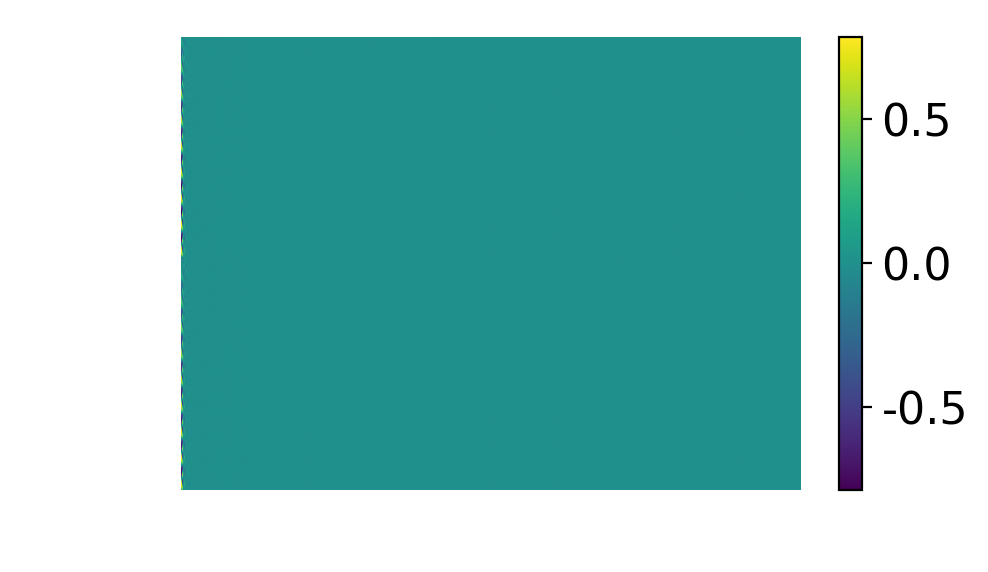

In [9]:
# The starry model
ydeg = 15
phase0 = -56.5
# JD 2458325.5 = ERA 303.5 (https://dc.zah.uni-heidelberg.de/apfs/times/q/form)
ny = (ydeg + 1) ** 2 - 1

# Get the design matrix
X, X0 = earthshine.design_matrix(time, ydeg=ydeg, nt=1, phase0=phase0, fit_linear_term=False)
X = np.hstack(([X * C[:, k].reshape(-1, 1) for k in range(nt)]))

# Plot it
fig, ax = plt.subplots(1, figsize=(5, 3))
im = ax.imshow(X, aspect="auto")
plt.colorbar(im)
ax.axis('off');

In [10]:
# The pixelization matrix
npix = 1000
ntsamp = 10
res = int(np.sqrt(0.5 * npix))
npix = 2 * res ** 2
y = np.sin(np.linspace(-np.pi / 2, np.pi / 2, res + 2))[1:-1]
x = np.zeros(res)
thetas = np.linspace(-180, 180, 2 * res)
map_ = starry.Map(ydeg)
P = np.array([np.array(map_.linear_intensity_model(theta=theta, x=x, y=y)) for theta in thetas])
P0 = P[:, :, 0].reshape(-1)
P = P[:, :, 1:].reshape(-1, ny)

In [11]:
# Time samples
tsamp = np.linspace(0, len(time) - 1, ntsamp, dtype=int)
P = np.vstack([np.hstack([P * C[j, k] for k in range(nt)]) for j in tsamp])
P0 = np.concatenate([P0 for j in tsamp])

In [12]:
# Define the priors
def amp_l(l, a=2.0, b=1.5, c=0.035):
    """The power spectrum prior."""
    if l == 0:
        return np.nan
    elif l < a:
        return c * l ** b
    else:
        return c * a ** (2 * b) * l ** -b

def amp_t(t):
    """The prior on the temporal components."""
    if t == 0:
        return 1
    else:
        return 10 * np.exp(-(t - 1))

# The L2 prior on the Ylms
LX = np.ones(ny * nt)
LXL = np.ones(ny * nt)
LXT = np.ones(ny * nt)
i = 0
for n in range(nt):
    for l in range(1, ydeg + 1):
        for m in range(-l, l + 1):
            LXL[i] = amp_l(l) ** 2
            LXT[i] = amp_t(n) ** 2
            LX[i] = LXT[i] * LXL[i]
            i += 1

# Downweight the prior by this amount
# when computing the linear solution
linLXfac = (0.001) ** 2
            
# Define the L2 prior on the multiplicative model
LB = (10.0) ** 2 * np.ones(B.shape[1])

# The (inverse) penalty factor for intensity outside of [0, 1]
LP = (1e-3) ** 2

In [13]:
# Initialize the models
nc = len(time)
nl = len(flux)

Xwx = np.ones(nc)
Bwb = np.array([np.ones(nc) * amp for i in range(nl)]).reshape(-1)

# The diagonal of the data covariance
D = flux_err.reshape(-1) ** 2

# The flattened light curves
data = flux.reshape(-1)

# The augmented starry design matrix
XBig = np.tile(X, (nl, 1))
X0Big = np.tile(X0, (nl, 1)).reshape(-1)

In [14]:
# Solve the bilinear problem iteratively. Here our loss function is *just* the L2
# norm, so we downweight the power spectrum prior on the coefficients to keep
# the map positive and well-behaved. This will serve as an initial guess for the
# TensorFlow optimization below.
niter = 50
loss = np.zeros(niter)
like = np.zeros(niter)
wb = np.zeros((nl, B.shape[1]))
for n in tqdm(range(niter)):
    # Compute the baseline model: one per light curve
    for i in range(nl):
        l = slice(i * nc, (i + 1) * nc, 1)
        wb[i] = starry.MAP(B, LB, D[l] / (Xwx * amp) ** 2, data[l] / (Xwx * amp))
        Bwb[l] = np.dot(B, wb[i]) * amp

    # Compute the starry model: shared by all light curves
    wx = starry.MAP(XBig, linLXfac * LX, D / Bwb ** 2, data / Bwb - X0Big)
    Xwx = np.dot(X, wx) + X0
    
    # Render the image (for the loss calculation)
    img = np.dot(P, wx) + P0
    
    # Compute the loss: chi squared
    model = Bwb * np.tile(Xwx, nl)
    like[n] = 0.5 * np.sum(((data - model) ** 2 / D))
    loss[n] = like[n] + 0.5 * (
        np.sum([wb[i] ** 2 / LB for i in range(nl)]) +
        np.sum(wx ** 2 / LX) +
        np.sum(img[img < 0] ** 2 / LP) + 
        np.sum((img[img > 1] - 1) ** 2 / LP)
    )

100%|██████████| 50/50 [20:25<00:00, 23.89s/it]


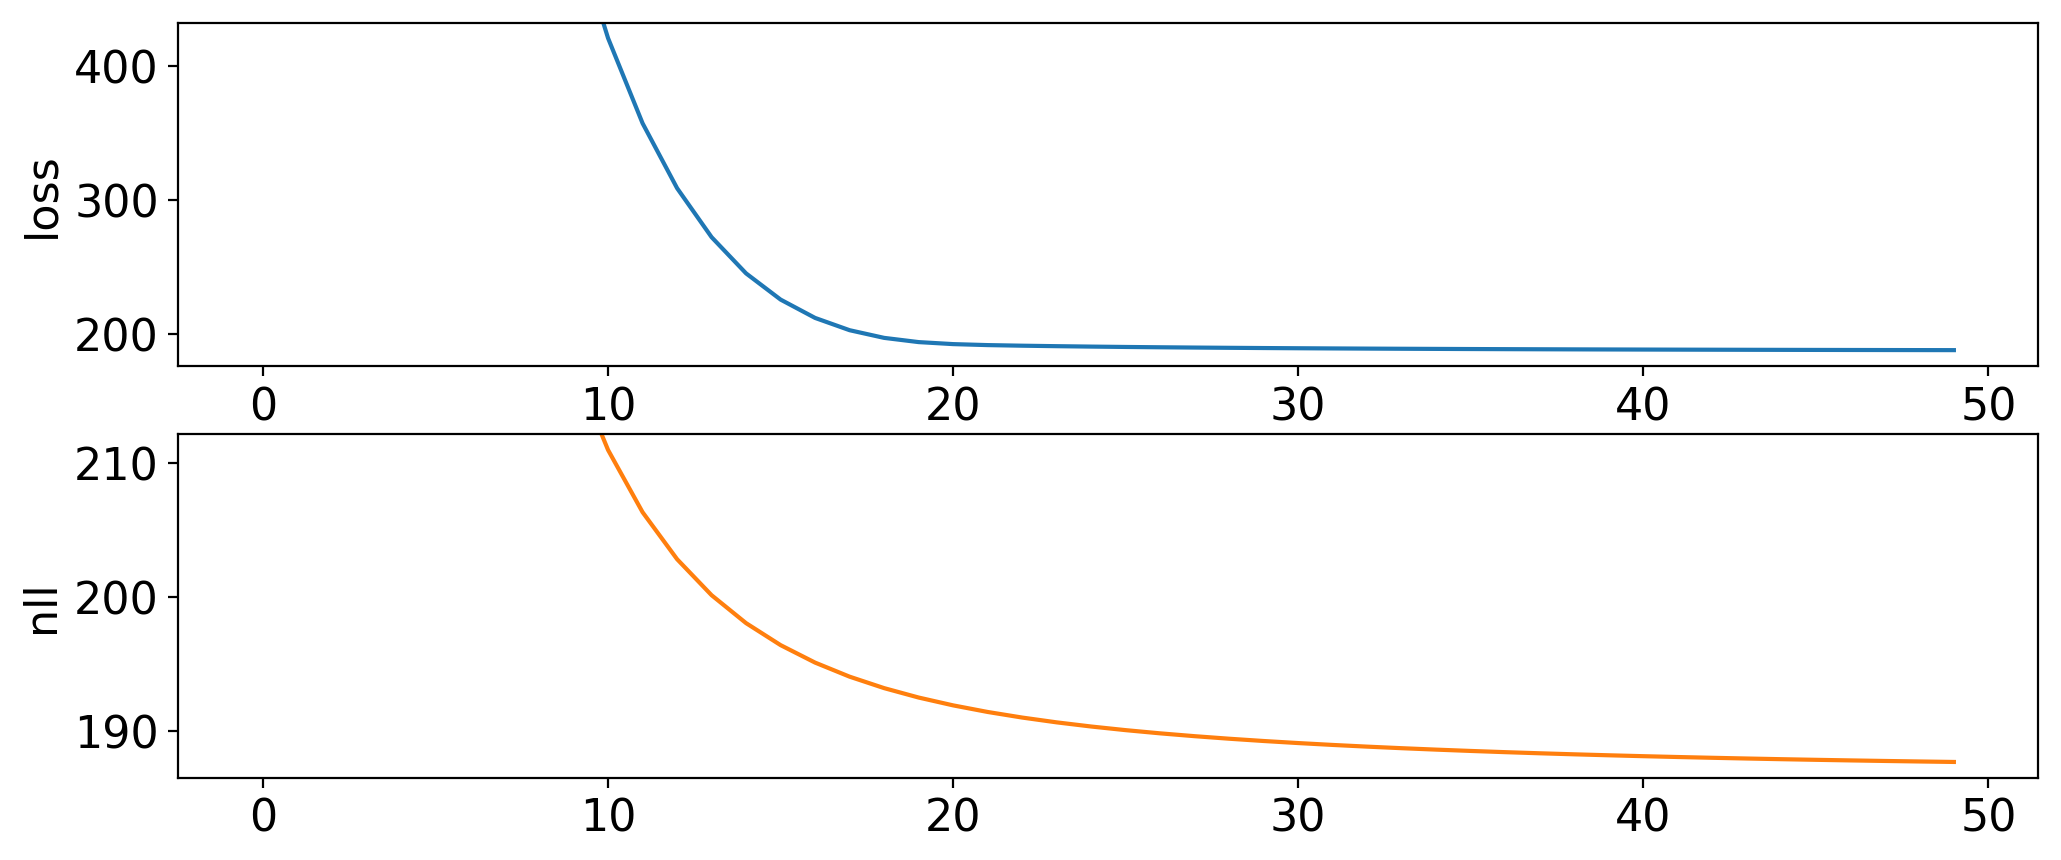

In [15]:
# Plot the loss and the negative log likelihood
fig, ax = plt.subplots(2, figsize=(12, 5))
burn = 10
ax[0].plot(loss[burn:] / (nc * nl), alpha=0)
ax[1].plot(like[burn:] / (nc * nl), alpha=0)
ax[0].set_ylim(*ax[0].get_ylim())
ax[1].set_ylim(*ax[1].get_ylim())
ax[0].plot(loss / (nc * nl), color="C0");
ax[1].plot(like / (nc * nl), color="C1");
ax[0].set_ylabel("loss")
ax[1].set_ylabel("nll");

In [16]:
# Declare the TensorFlow model
session = tf.Session()
T = tf.float64

# The data
tdata = tf.constant(data.reshape(-1, 1), dtype=T)
tcov = tf.constant(D.reshape(-1, 1), dtype=T)
tamp = tf.constant(np.tile(amp, nl).reshape(-1, 1), dtype=T)

# The constant matrices
tB = tf.constant(B, dtype=T)
tX = tf.constant(X, dtype=T)
tX0 = tf.constant(X0.reshape(-1, 1), dtype=T)
tP = tf.constant(P, dtype=T)
tP0 = tf.constant(P0.reshape(-1, 1), dtype=T)
tC = tf.constant(C, dtype=T)

# The priors
tLB = tf.constant(np.tile(LB, (nl, 1)).T, dtype=T)
tLXT = tf.constant(LXT.reshape(-1, 1), dtype=T)
tLXL = tf.constant(LXL.reshape(-1, 1), dtype=T)
tLP = tf.constant(LP, dtype=T)

# The things we're solving for
twb = tf.Variable(wb.T, dtype=T)
twx = tf.Variable(wx.reshape(-1, 1), dtype=T)

# This is our actual model
tBwb = tf.reshape(tf.transpose(tf.matmul(tB, twb)), [-1, 1]) * tamp
tXwx = tf.matmul(tX, twx) + tX0
tmodel = tBwb * tf.tile(tXwx, [nl, 1])

# The chi^2 part of the loss function
tloss_like = 0.5 * tf.reduce_sum(tf.squared_difference(tdata, tmodel) / tcov)

# The prior on the baseline model
tloss_mult = 0.5 * tf.reduce_sum(tf.square(twb) / tLB)

# The prior on the temporal components
tloss_polyt = 0.5 * tf.reduce_sum(tf.square(twx) / tLXT)

# Enforce a constant power spectrum (in time)
tyoft = tf.matmul(tf.transpose(tf.reshape(twx, (nt, ny))), tf.transpose(tC))
tloss_spec = 0.5 * tf.reduce_sum(tf.square(tyoft) / tLXL[:ny])

# Render the map on a coarse theta-phi-time grid and 
# compute the penalty on intensities outside of [0, 1]
timg = tf.matmul(tP, twx) + tP0
tloss_neg = 0.5 * tf.reduce_sum(tf.square(tf.where(timg < 0, timg, tf.zeros_like(timg))) / tLP)
tloss_pos = 0.5 * tf.reduce_sum(tf.square(tf.where(timg > 1, timg - 1, tf.zeros_like(timg))) / tLP)

# The total loss function
tloss = tloss_like + tloss_mult + tloss_polyt + tloss_spec + tloss_neg + tloss_pos

# Set up the optimizer
var_list = [twb, twx]
opt = tf.train.AdamOptimizer().minimize(tloss, var_list=var_list)
session.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
# Iterate: we are now solving the full problem, with the full loss function
# specified by all our crazy constraints
tniter = 1000
like = np.zeros(tniter)
loss = np.zeros(tniter)
for i in tqdm(range(tniter)):
    session.run(opt)
    like[i] = session.run(tloss_like)
    loss[i] = session.run(tloss)

100%|██████████| 1000/1000 [02:43<00:00,  6.10it/s]


In [18]:
# Get the values of a bunch of the TF variables
wb = session.run(tf.squeeze(twb)).T
wx = session.run(tf.squeeze(twx))
Bwb = session.run(tf.squeeze(tBwb))
Xwx = session.run(tf.squeeze(tXwx))
model = session.run(tf.squeeze(tmodel))
yoft = session.run(tyoft)
img = session.run(tf.squeeze(timg))

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


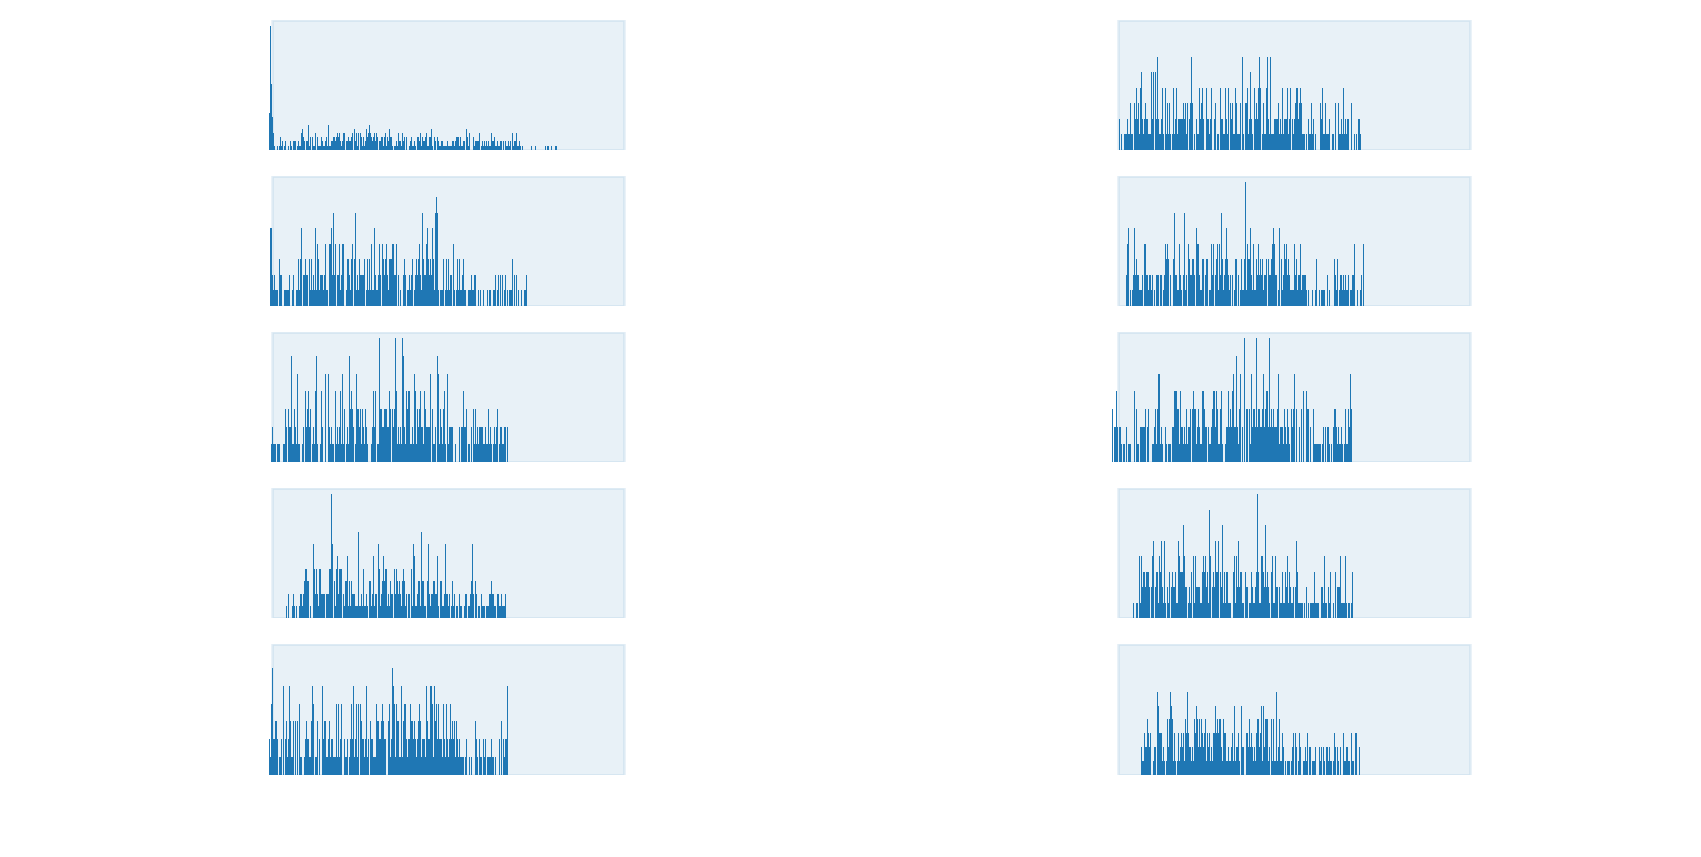

In [19]:
# Plot the distribution of intensities throughout the timeseries
fig, ax = plt.subplots(ntsamp // 2, 2, figsize=(10, 5))
ax = ax.flatten()
for n in range(ntsamp):
    ax[n].hist(img[n*npix:(n+1)*npix], bins=500, normed=True);
    ax[n].axis('off')
    ax[n].set_xlim(-0.5, 1.5)
    ax[n].axvspan(0, 1, color="C0", alpha=0.1)

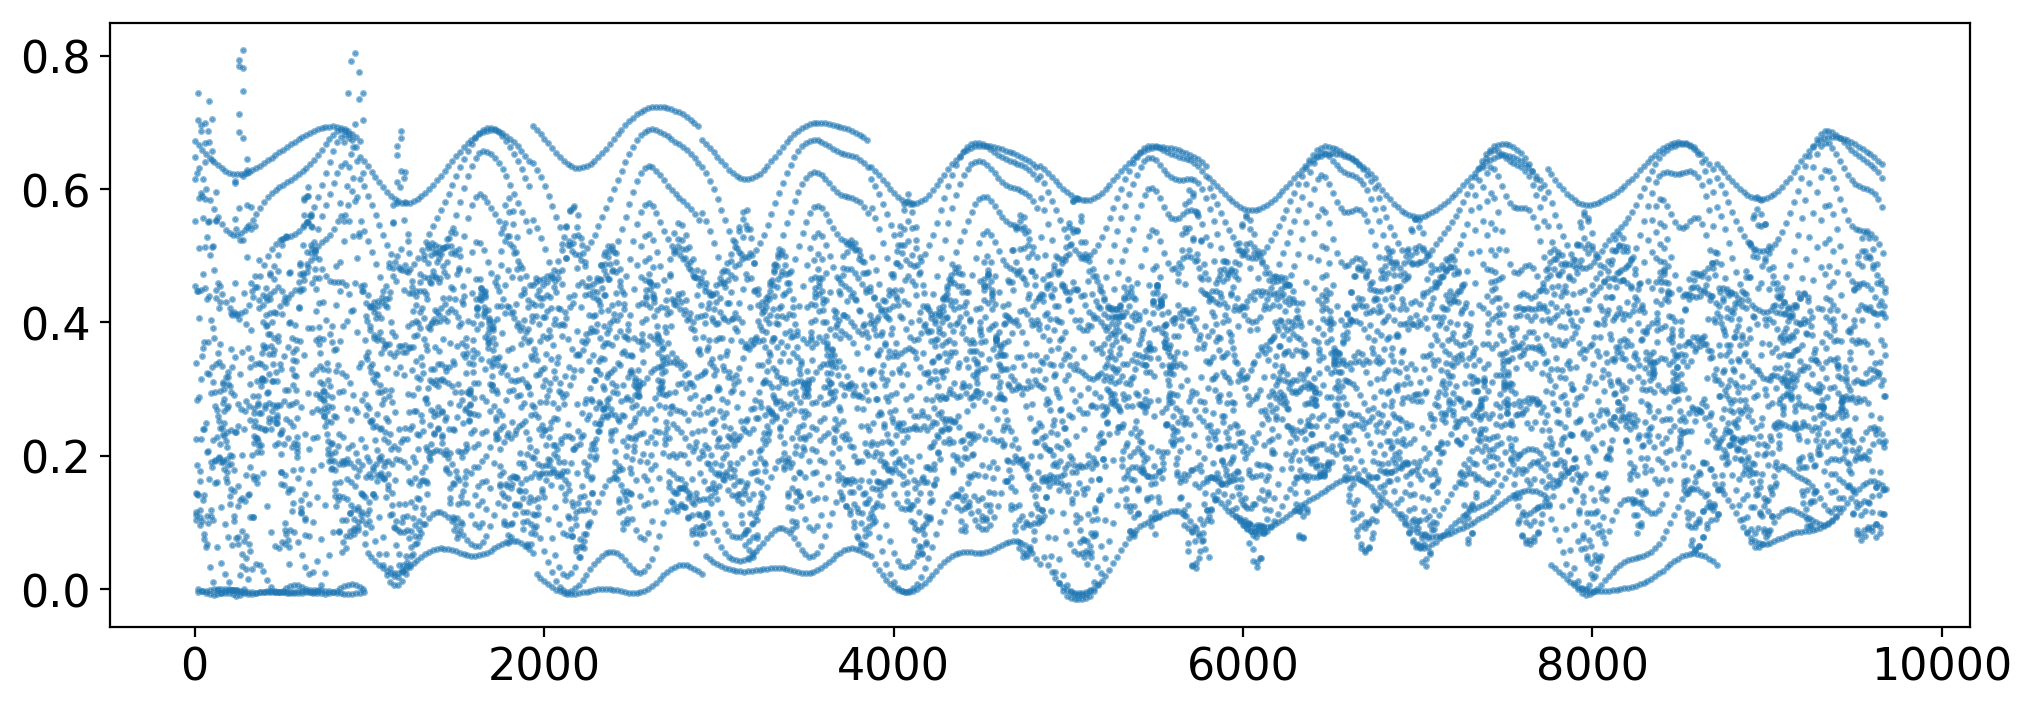

In [20]:
# Plot the flattened image as a function of time
img = np.dot(P, wx) + P0
plt.plot(img.flatten(), 'C0.', ms=3, alpha=0.5);

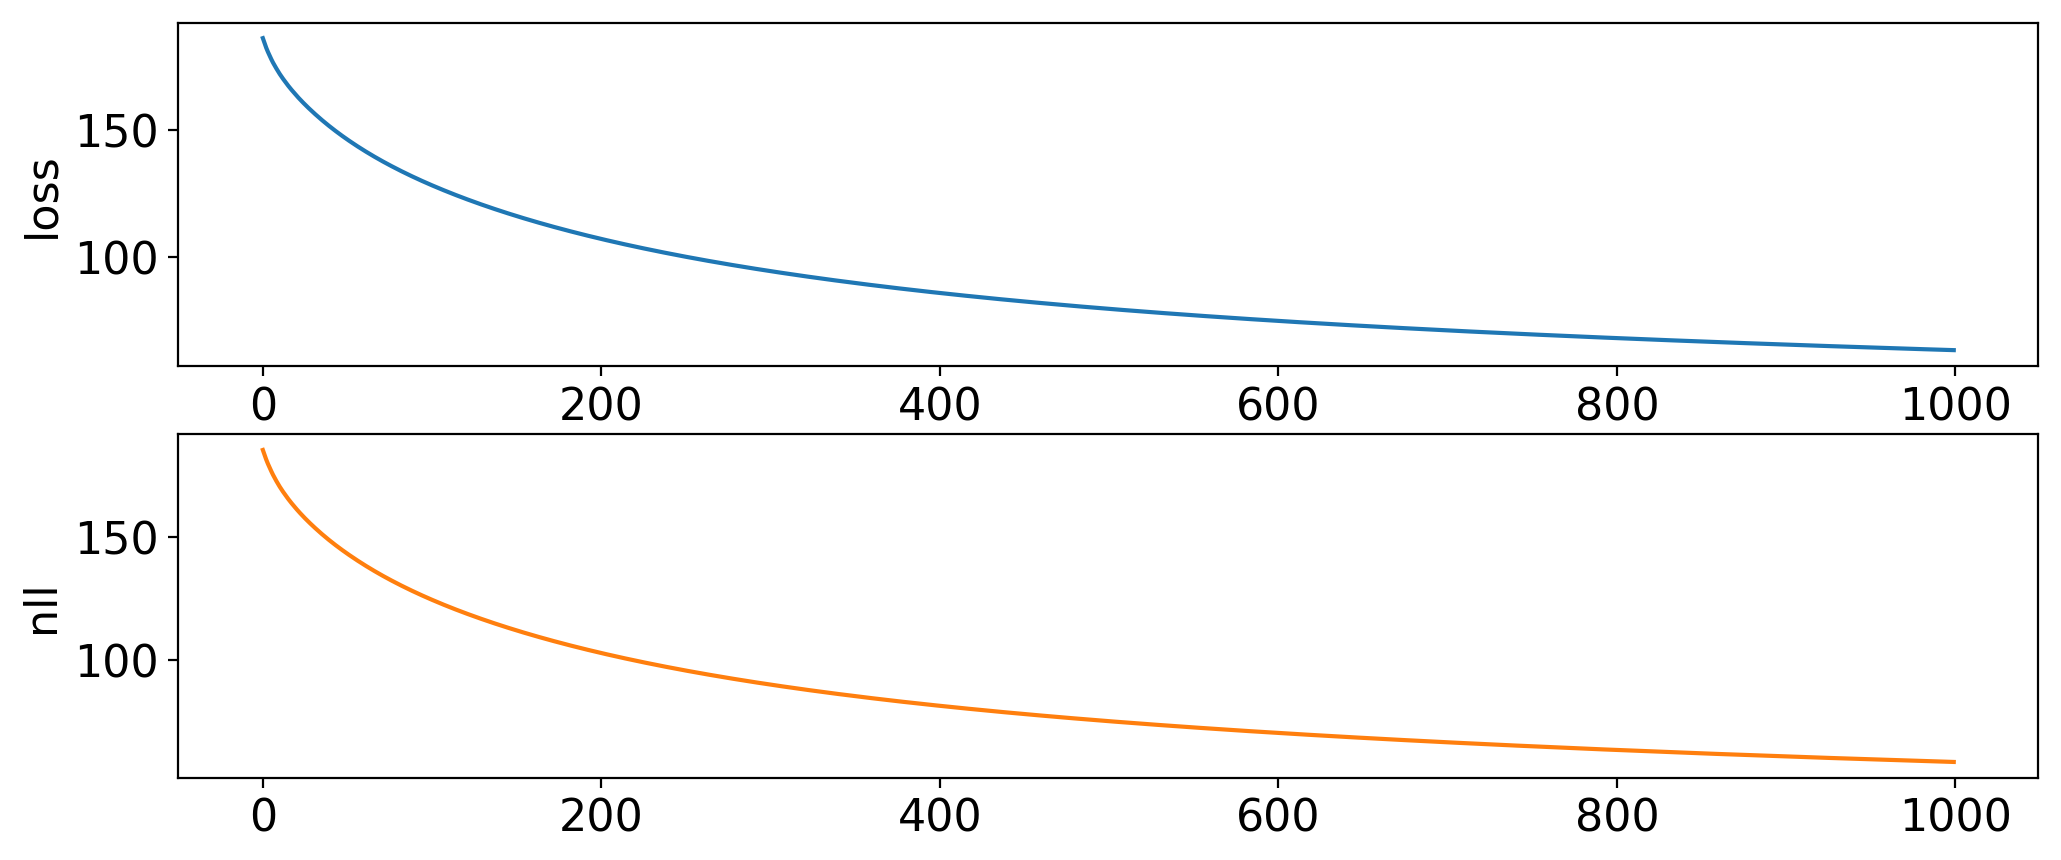

In [21]:
# Plot the loss and likelihood functions
fig, ax = plt.subplots(2, figsize=(12, 5))
burn = 0
ax[0].plot(loss[burn:] / (nc * nl), alpha=0)
ax[1].plot(like[burn:] / (nc * nl), alpha=0)
ax[0].set_ylim(*ax[0].get_ylim())
ax[1].set_ylim(*ax[1].get_ylim())
ax[0].plot(loss / (nc * nl), color="C0");
ax[1].plot(like / (nc * nl), color="C1");
ax[0].set_ylabel("loss")
ax[1].set_ylabel("nll");

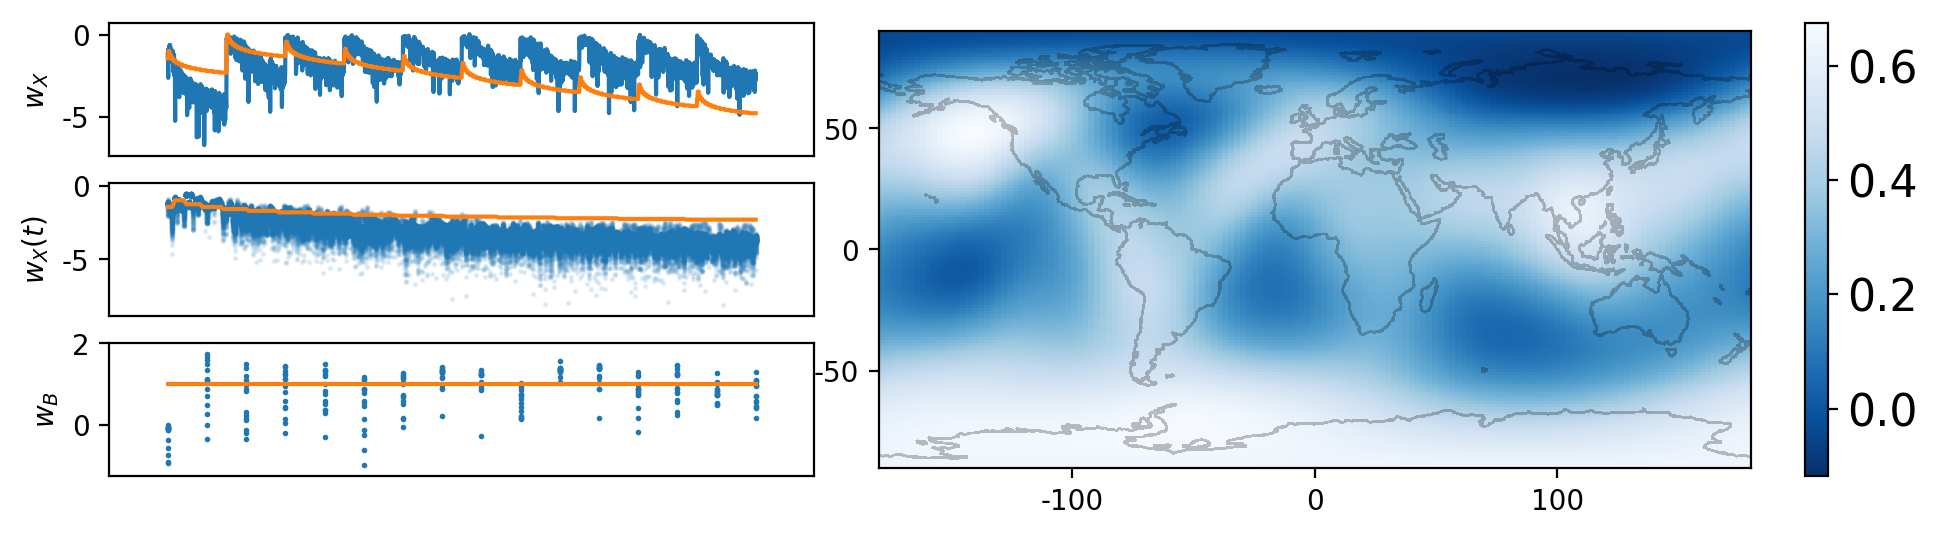

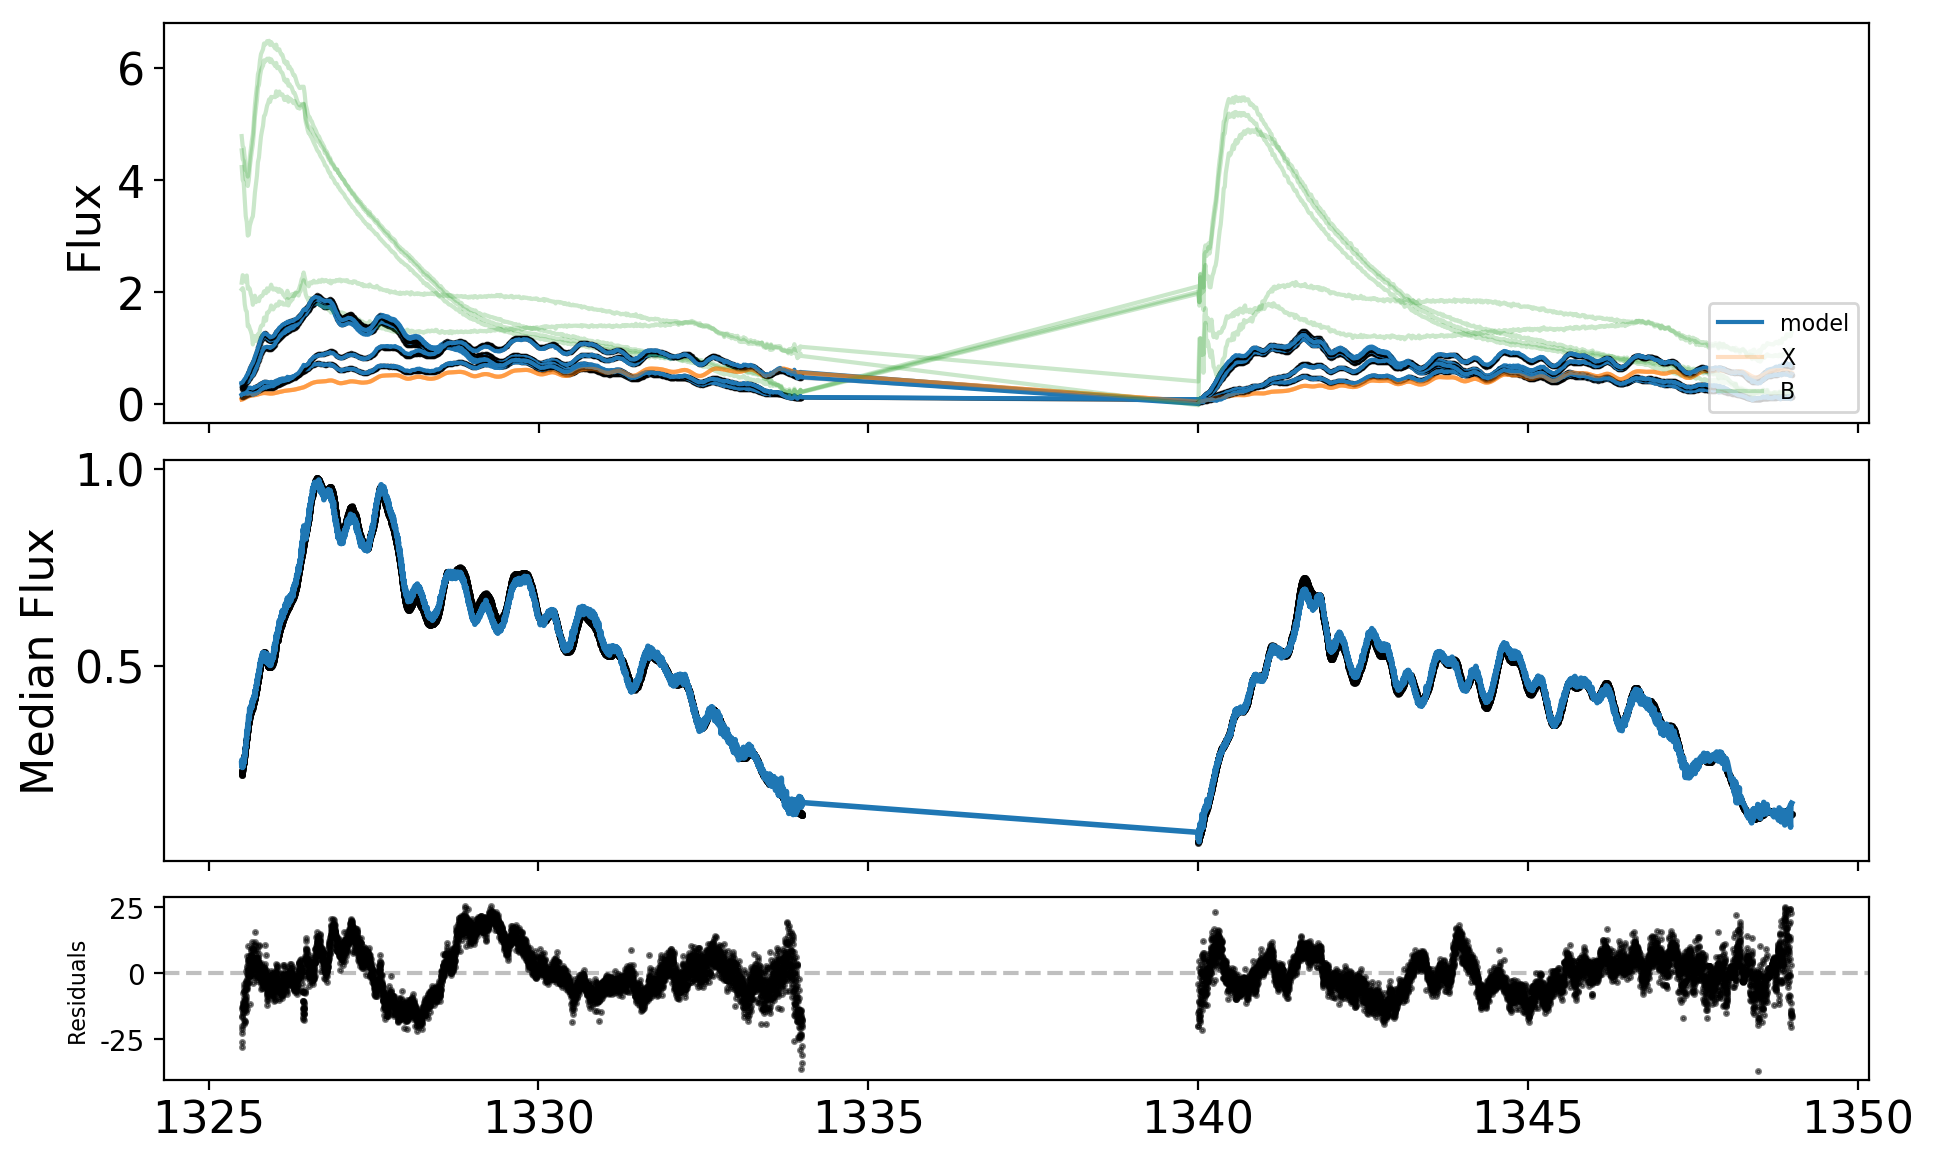

In [22]:
# Set the map coefficients
map = starry.Map(ydeg=ydeg, nt=nt, reflected=True)
map[0, 0, 0] = 1
for n in range(nt):
    map[1:, :, n] = wx[n * ny:(n + 1) * ny]

# Plot the coefficients and the map at t = 0
fig = plt.figure(figsize=(12, 3))
ax = [plt.subplot2grid((3, 5), (0, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (1, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (2, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (0, 2), rowspan=3, colspan=3)]
for i, axis in enumerate(ax):
    for tick in axis.xaxis.get_major_ticks() + axis.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    if i < 3:
        axis.set_xticks([])
        axis.margins(0.1, 0.1)
ax[0].plot(np.log10(np.abs(wx)), '-')
ax[0].plot(np.log10(np.sqrt(LX)), '-')
ax[0].set_ylabel(r"$w_X$", fontsize=10)
for k in np.arange(len(time), dtype=int)[::50]:
    ax[1].plot(np.log10(np.abs(yoft[:, k])), 'C0.', ms=2, alpha=0.1)
ax[1].plot(np.log10(np.sqrt(LXL[:ny])), 'C1-')
ax[1].set_ylabel(r"$w_X(t)$", fontsize=10)
for i in range(nl):
    ax[2].plot(np.log10(np.abs(wb[i])), 'C0.', ms=2)
ax[2].plot(np.log10(np.sqrt(LB)), 'C1-')
ax[2].set_ylabel(r"$w_B$", fontsize=10)
cmap = plt.get_cmap("Blues_r")
cmap.set_under('w')  
map_ = starry.Map(ydeg)
j = np.argmin(np.abs(t))
map_[:, :] = np.sum([map[:, :, k] * C[j, k] for k in range(nt)], axis=0)
Z = map_.render(res=150, projection="rect", cmap=cmap)[0]
im = ax[3].imshow(Z, origin="lower", cmap=cmap, extent=(-180, 180, -90, 90));
fig.colorbar(im)
ax[3].imshow(coastlines, extent=(-180, 180, -90, 90), alpha=0.25)

# Plot the data and model
thin = 10
nsamp = 5
fig = plt.figure(figsize=(11, 7))
ax = [plt.subplot2grid((5, 1), (0, 0), rowspan=2, colspan=1),
      plt.subplot2grid((5, 1), (2, 0), rowspan=2, colspan=1),
      plt.subplot2grid((5, 1), (4, 0), rowspan=1, colspan=1)]
tthin = time[::thin]
inds = np.arange(nl, dtype=int)
np.random.shuffle(inds)
inds = inds[:nsamp]
for i in inds:
    # Indices for this light curve
    l = slice(i * nc, (i + 1) * nc, 1)
    ax[0].plot(tthin, data[l][::thin], 'k.', alpha=0.75, ms=2)
    ax[0].plot(tthin, data[l][::thin], 'k-', alpha=0.25, lw=1)
    ax[0].plot(tthin, model[l][::thin], color="C0", label="model" if i == inds[0] else None);
    ax[0].plot(tthin, Xwx[::thin], color="C1", alpha=0.25, label="X" if i == inds[0] else None);
    ax[0].plot(tthin, Bwb[l][::thin], color="C2", alpha=0.25, label="B" if i == inds[0] else None);
ax[1].plot(time, np.nanmedian([data[slice(i * nc, (i + 1) * nc, 1)] 
                               for i in range(nl)], axis=0), 'k.', alpha=0.75, ms=3)
ax[1].plot(time, np.nanmedian([model[slice(i * nc, (i + 1) * nc, 1)] 
                               for i in range(nl)], axis=0), 'C0-', lw=2)
ax[2].plot(time, np.nanmedian([((data - model) / np.sqrt(D))[slice(i * nc, (i + 1) * nc, 1)] 
                               for i in range(nl)], axis=0), 'k.', alpha=0.5, ms=3)
ax[0].set_ylabel("Flux")
ax[1].set_ylabel("Median Flux")
ax[2].set_ylabel("Residuals", fontsize=8)
ax[0].legend(fontsize=8, loc="lower right")
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].axhline(0, color="k", alpha=0.25, ls="--");
for tick in ax[2].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)

In [23]:
# Render the map over time
Z = []
for j in tqdm(np.linspace(0, len(time) - 1, 50, dtype=int), total=50):
    map_[:, :] = np.sum([map[:, :, k] * C[j, k] for k in range(nt)], axis=0)
    Z.append(map_.render(res=150, projection="rect", cmap=cmap)[0])

# Animate it
map.show(np.array(Z), res=150, projection="rect", source=None, cmap=cmap)

100%|██████████| 50/50 [00:18<00:00,  2.58it/s]


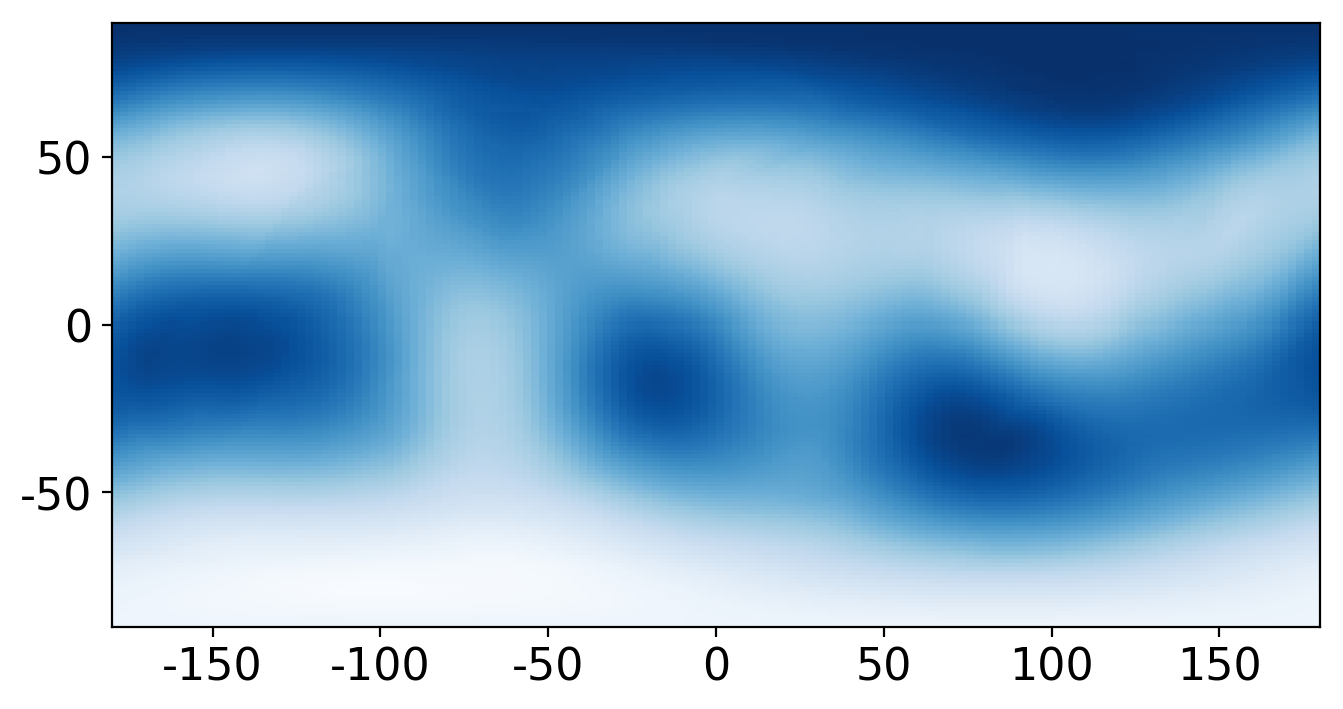

In [24]:
# Compute the median map
plt.imshow(np.median(np.array(Z), axis=0), cmap=cmap, extent=(-180, 180, -90, 90), origin="lower")

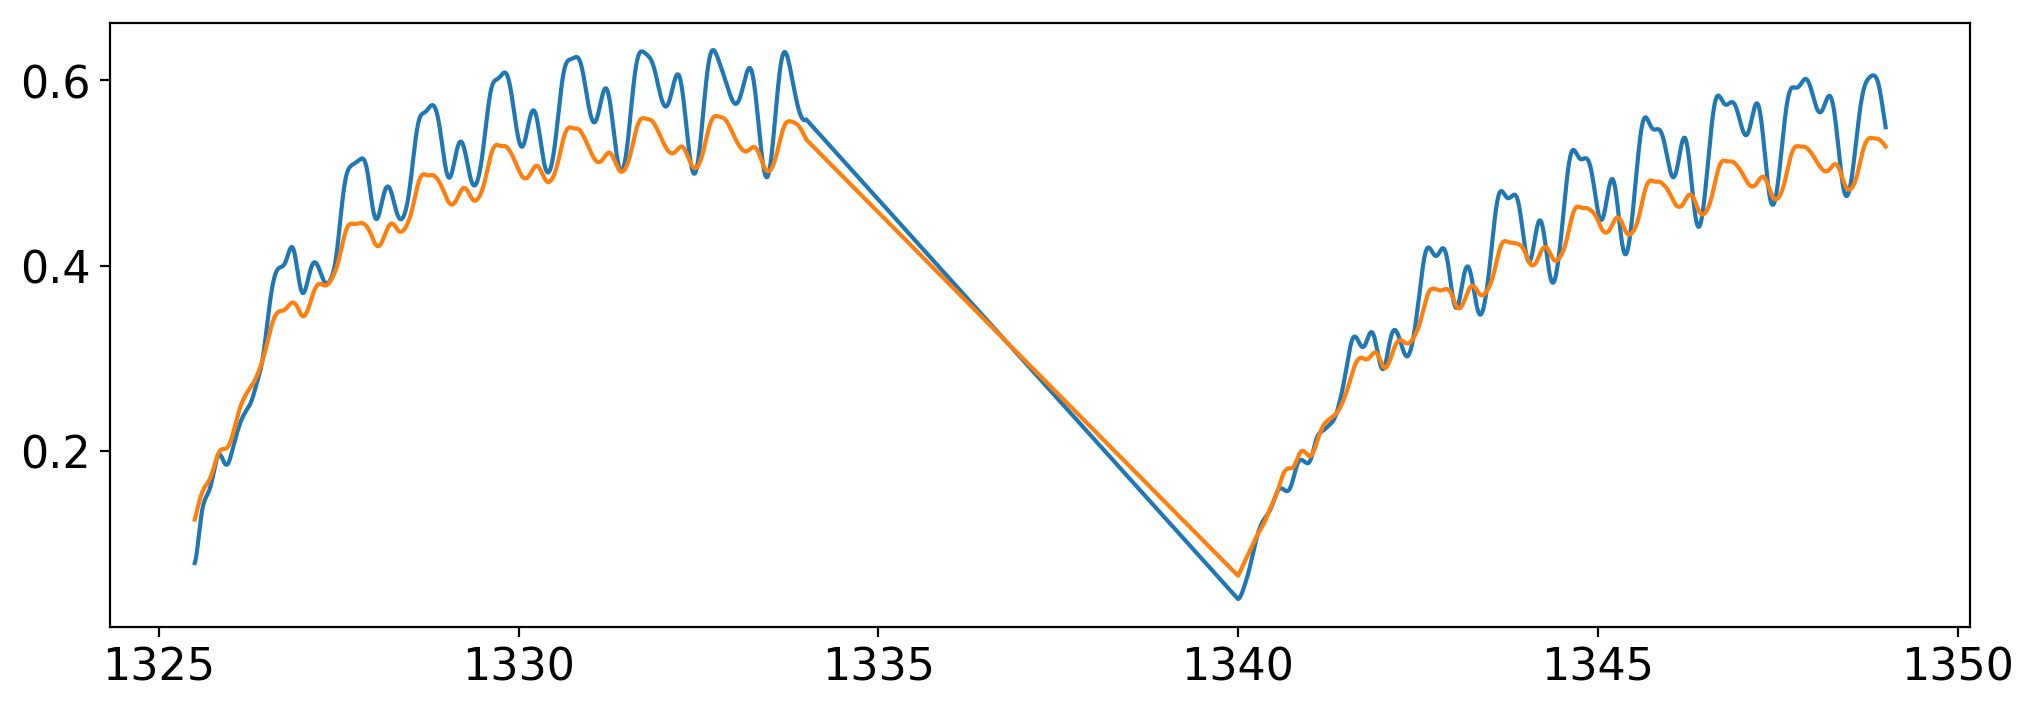

In [25]:
# Compare to "ground truth"
plt.plot(time, Xwx)
plt.plot(time, np.load("../data/Xwx_truth.npz")["Xwx"]);